# MediXGen: AI-Powered Medical Report Generation from X-Rays

## Import Libraries

In [116]:
import torch
import torch.nn as nn
import torchvision.models as models
import h5py
import time
from tqdm import tqdm
import torch.optim as optim
from torch.utils.data import Dataset, DataLoader
import pandas as pd
import numpy as np
import pickle
import re
from collections import Counter
from torch.nn.utils.rnn import pad_sequence
from torchvision.models import densenet121
from rouge_score import rouge_scorer
from sklearn.metrics import precision_score, recall_score, f1_score
from nltk.translate.bleu_score import sentence_bleu
import torch
from torch.utils.data import Dataset, DataLoader
from torchvision import transforms
from PIL import Image
import os


## Feature Extraction using ChexNet Pretrained Weights

In [117]:
# Load Pretrained DenseNet-121 from PyTorch
densenet = models.densenet121(weights=None)
state_dict = densenet.state_dict()

# Load the Keras Weights from .h5 File
keras_weights_path = 'brucechou1983_CheXNet_Keras_0.3.0_weights.h5'
with h5py.File(keras_weights_path, 'r') as f:
    keras_weights = {k: np.array(v) for k, v in f.items()}

# Map Keras Weights to PyTorch Model
def load_weights(state_dict, keras_weights):
    for key in keras_weights.keys():
        if 'kernel' in key or 'bias' in key:  # Identify weight types
            pytorch_key = key.replace('kernel', 'weight').replace('bias', 'bias')
            pytorch_key = pytorch_key.replace('/', '.')  # Adjust naming format
            
            if pytorch_key in state_dict:
                weight = torch.tensor(keras_weights[key])
                if len(weight.shape) == 4:  # For Conv weights
                    weight = weight.permute(3, 2, 0, 1)
                state_dict[pytorch_key] = weight
    return state_dict

# Apply Weights to PyTorch DenseNet
state_dict = load_weights(state_dict, keras_weights)
densenet.load_state_dict(state_dict)

print("Weights loaded successfully into PyTorch DenseNet-121 model.")

# Step 4: Use DenseNet-121 as a Feature Extractor
class CheXNetFeatureExtractor(nn.Module):
    def __init__(self, densenet):
        super(CheXNetFeatureExtractor, self).__init__()
        self.features = densenet.features
        self.global_avg_pool = nn.AdaptiveAvgPool2d((1, 1))  # Global Average Pooling
    
    def forward(self, x):
        x = self.features(x)
        x = self.global_avg_pool(x)
        x = torch.flatten(x, 1)
        return x

# Instantiate Feature Extractor
chexnet = CheXNetFeatureExtractor(densenet)


Weights loaded successfully into PyTorch DenseNet-121 model.


In [118]:
# Testing of loaded model
input_tensor = torch.randn(1, 3, 224, 224)
output = chexnet(input_tensor)
print("Feature Vector Shape:", output.shape)  # Should be [1, 1024]

Feature Vector Shape: torch.Size([1, 1024])


In [119]:
# Load Dataset
train_dataset = pd.read_csv('Train_Data.csv')
valid_dataset = pd.read_csv('CV_Data.csv')
test_dataset = pd.read_csv('Test_Data.csv')

# Tokenize and Clean Text
def clean_text(text):
    text = text.lower()
    text = re.sub(r"[^a-z0-9\s]", "", text)
    return text

# Build Vocabulary
def build_vocab(texts, min_freq=1):
    counter = Counter()
    for text in texts:
        counter.update(clean_text(text).split())

    vocab = {"<PAD>": 0, "<START>": 1, "<END>": 2, "<UNK>": 3}
    for word, freq in counter.items():
        if freq >= min_freq:
            vocab[word] = len(vocab)
    return vocab

# Create Vocabulary
vocab = build_vocab(train_dataset['Report'].values)
vocab_size = len(vocab)
print("Vocabulary Size:", vocab_size)

# Text to Sequence
def text_to_sequence(text, vocab):
    tokens = clean_text(text).split()
    return [vocab.get("<START>")] + [vocab.get(token, vocab["<UNK>"]) for token in tokens] + [vocab.get("<END>")]


Vocabulary Size: 1429


## Custom Tokenizer 

In [120]:
import re
from collections import Counter

class CustomTokenizer:
    def __init__(self, min_freq=1, special_tokens=["<PAD>", "<START>", "<END>", "<UNK>"]):
        """
        A custom tokenizer for converting text to token sequences and vice versa.
        
        Args:
            min_freq (int): Minimum frequency for a word to be included in the vocabulary.
            special_tokens (list): List of special tokens like <PAD>, <START>, etc.
        """
        self.word_index = {}  # Word to index mapping
        self.index_word = {}  # Index to word mapping
        self.min_freq = min_freq
        self.special_tokens = special_tokens
        self.word_counter = Counter()

        # Initialize special tokens
        for idx, token in enumerate(self.special_tokens):
            self.word_index[token] = idx
            self.index_word[idx] = token

    def fit_on_texts(self, texts):
        """
        Fit the tokenizer on a list of text data to build the vocabulary.
        
        Args:
            texts (list of str): List of text sequences.
        """
        # Count word frequencies
        for text in texts:
            tokens = self._clean_and_tokenize(text)
            self.word_counter.update(tokens)
        
        # Add words to the vocabulary if they meet the min_freq criteria
        for word, freq in self.word_counter.items():
            if freq >= self.min_freq and word not in self.word_index:
                idx = len(self.word_index)
                self.word_index[word] = idx
                self.index_word[idx] = word

    def texts_to_sequences(self, texts):
        """
        Convert a list of texts to sequences of word indices.
        
        Args:
            texts (list of str): List of text sequences.
        
        Returns:
            list of list of int: List of token index sequences.
        """
        sequences = []
        for text in texts:
            tokens = self._clean_and_tokenize(text)
            sequence = [self.word_index.get(token, self.word_index["<UNK>"]) for token in tokens]
            sequences.append(sequence)
        return sequences

    def sequences_to_texts(self, sequences):
        """
        Convert a list of sequences of word indices back to text.
        
        Args:
            sequences (list of list of int): List of token index sequences.
        
        Returns:
            list of str: List of text sequences.
        """
        texts = []
        for seq in sequences:
            text = " ".join([self.index_word.get(idx, "<UNK>") for idx in seq if idx != self.word_index["<PAD>"]])
            texts.append(text)
        return texts

    def _clean_and_tokenize(self, text):
        """
        Clean and tokenize text into a list of words.
        
        Args:
            text (str): Input text string.
        
        Returns:
            list of str: List of tokens.
        """
        text = text.lower()
        text = re.sub(r"[^a-z0-9\s]", "", text)  # Remove special characters
        return text.split()

    def __call__(self, text):
        """
        Makes the tokenizer callable for a single text input.
        
        Args:
            text (str): A single text sequence.
        
        Returns:
            list of int: Token index sequence.
        """
        tokens = self._clean_and_tokenize(text)
        return [self.word_index.get(token, self.word_index["<UNK>"]) for token in tokens]

In [121]:
# Initialize and Fit Tokenizer
tokenizer = CustomTokenizer()

# Concatenate all reports into a single list
all_reports = pd.concat([
    train_dataset['Report'],
    valid_dataset['Report'],
    test_dataset['Report']
]).values.tolist()

# Fit the tokenizer on all reports
tokenizer.fit_on_texts(all_reports)


In [122]:
vocab_size = len(tokenizer.word_index.keys()) + 1
vocab_size

1599

In [123]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

## Generate Embeddings using  GloVe Vectors

In [124]:
# Path to GloVe file
glove_path = 'glove.6B.300d.txt'

# Load GloVe Vectors into a Dictionary
def load_glove_vectors(glove_path):
    glove_dict = {}
    with open(glove_path, 'r', encoding='utf-8') as f:
        for line in f:
            values = line.strip().split()
            word = values[0]
            vector = np.asarray(values[1:], dtype='float32')
            glove_dict[word] = vector
    return glove_dict

# Load GloVe
glove_vectors = load_glove_vectors(glove_path)
print(f"Loaded {len(glove_vectors)} words from GloVe.")

Loaded 400000 words from GloVe.


In [125]:
embedding_matrix = np.zeros((vocab_size,300))
for word, i in tokenizer.word_index.items():
    if word in glove_vectors.keys():
        vec = glove_vectors[word]
        embedding_matrix[i] = vec
    else:
        continue

## Custom DataSet For X-Rays

In [126]:
class CheXNetReportDataset(Dataset):
    def __init__(self, csv_file, root_dir, chexnet, tokenizer, transform=None, max_length=153):
        """
        Args:
            csv_file (str): Path to the CSV file containing Person_id and Report.
            root_dir (str): Root directory containing the image files.
            chexnet (CheXNetFeatureExtractor): Pretrained CheXNet feature extractor.
            tokenizer (CustomTokenizer): Tokenizer for converting text to sequences.
            transform: Image preprocessing transforms.
            max_length (int): Maximum length of tokenized reports (padded/truncated).
        """
        self.data = pd.read_csv(csv_file)
        self.root_dir = root_dir
        self.chexnet = chexnet
        self.tokenizer = tokenizer
        self.transform = transform
        self.max_length = max_length

    def __len__(self):
        return len(self.data)

    def pad_sequence(self, sequence):
        """Pad or truncate a tokenized sequence to the maximum length."""
        if len(sequence) < self.max_length:
            sequence += [0] * (self.max_length - len(sequence))  # Pad with 0 (e.g., <PAD>)
        else:
            sequence = sequence[:self.max_length]
        return sequence

    def load_image(self, image_path):
        """Load and preprocess an image."""
        image = Image.open(image_path).convert("RGB")
        
        if self.transform:
            image = self.transform(image)
        return image

    def __getitem__(self, idx):
        person_id = self.data.iloc[idx]["Person_id"]
        report = self.data.iloc[idx]["Report"]
        image_path = os.path.join(self.root_dir, self.data.iloc[idx]["Image1"])
        image = self.load_image(image_path)

        # Extract features using CheXNet
        with torch.no_grad():
            img_feature = self.chexnet(image.unsqueeze(0)).squeeze(0)

        # Tokenize and pad the report
        tokenized_report = self.tokenizer(report)
        padded_report = self.pad_sequence(tokenized_report)

        # Calculate caption lengths
        length = min(len(tokenized_report), self.max_length)

        return img_feature, torch.tensor(padded_report, dtype=torch.long), torch.tensor(tokenized_report, dtype=torch.long), length



In [127]:
BATCH_SIZE=32
EPOCHS = 20

# Image preprocessing transforms for CheXNet feature extraction
image_transform = transforms.Compose([
    transforms.Resize((224, 224)),
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])
])

# DataLoader Function
def create_dataloader(dataset, batch_size, shuffle=True):
    return DataLoader(dataset, batch_size=batch_size, shuffle=shuffle, num_workers=2,pin_memory=True)

root_dir = "NLMCXR/images"
# Assuming chexnet is a preloaded dictionary and tokenizer is initialized
dataset_train = CheXNetReportDataset("Train_Data.csv",root_dir,chexnet=chexnet,tokenizer=tokenizer,transform=image_transform)
dataset_test = CheXNetReportDataset("Test_Data.csv",root_dir,chexnet=chexnet,tokenizer=tokenizer,transform=image_transform)
dataset_valid = CheXNetReportDataset("CV_Data.csv",root_dir,chexnet=chexnet,tokenizer=tokenizer,transform=image_transform)

data_loader_train = create_dataloader(dataset_train, BATCH_SIZE)
data_loader_test = create_dataloader(dataset_test, BATCH_SIZE)
data_loader_valid = create_dataloader(dataset_valid, BATCH_SIZE)

# Print number of samples in each dataset
print(f"Number of samples in the training dataset: {len(dataset_train)}")
print(f"Number of samples in the validation dataset: {len(dataset_valid)}")
print(f"Number of samples in the test dataset: {len(dataset_test)}")

# Print number of batches in each DataLoader
print(f"Number of batches in the training DataLoader: {len(data_loader_train)}")
print(f"Number of batches in the validation DataLoader: {len(data_loader_valid)}")
print(f"Number of batches in the test DataLoader: {len(data_loader_test)}")


Number of samples in the training dataset: 2758
Number of samples in the validation dataset: 550
Number of samples in the test dataset: 399
Number of batches in the training DataLoader: 87
Number of batches in the validation DataLoader: 18
Number of batches in the test DataLoader: 13


In [12]:
from datetime import datetime
# Get the current timestamp
current_timestamp = datetime.now()
# Format the timestamp without spaces or dashes (e.g., YYYYMMDD_HHMMSS)
formatted_timestamp = current_timestamp.strftime("%Y%m%d_%H%M%S")
formatted_timestamp

model_name = f'encoder_decoder_epoch_final_{formatted_timestamp}.pth'
model_name

'encoder_decoder_epoch_final_20241219_231215.pth'

In [128]:
max_seq_len = 153 

## Model

In [185]:
class Attention(nn.Module):
    def __init__(self, encoder_dim, decoder_dim, attention_dim):
        """
        Args:
            encoder_dim: Feature dimension of the encoder (image branch).
            decoder_dim: Hidden dimension of the decoder (LSTM hidden state).
            attention_dim: Dimension of the attention layer.
        """
        super(Attention, self).__init__()
        self.encoder_att = nn.Linear(encoder_dim, attention_dim)  # Encoder projection
        self.decoder_att = nn.Linear(decoder_dim, attention_dim)  # Decoder projection
        self.full_att = nn.Linear(attention_dim, 1)  # Scalar attention score
        self.relu = nn.ReLU()
        self.softmax = nn.Softmax(dim=1)  # Normalize scores

    def forward(self, encoder_out, decoder_hidden):
        """
        Forward pass for attention mechanism.
        Args:
            encoder_out: Features from the encoder (batch_size, seq_len, encoder_dim).
            decoder_hidden: Hidden state from the decoder (batch_size, decoder_dim).
        Returns:
            context: Weighted sum of encoder outputs (batch_size, encoder_dim).
            alpha: Attention weights (batch_size, seq_len).
        """
        att1 = self.encoder_att(encoder_out)  # (batch_size, seq_len, attention_dim)
        att2 = self.decoder_att(decoder_hidden).unsqueeze(1)  # (batch_size, 1, attention_dim)
        att = self.full_att(self.relu(att1 + att2)).squeeze(2)  # (batch_size, seq_len)
        alpha = self.softmax(att)  # Attention weights (batch_size, seq_len)
        context = (encoder_out * alpha.unsqueeze(2)).sum(dim=1)  # Context vector (batch_size, encoder_dim)
        return context, alpha

class DecoderWithAttention(nn.Module):
    def __init__(self, vocab_size, embedding_dim, encoder_dim, decoder_dim, attention_dim):
        """
        Decoder with attention for image captioning.
        Args:
            vocab_size: Size of the vocabulary.
            embedding_dim: Dimension of word embeddings.
            encoder_dim: Dimension of encoder output features.
            decoder_dim: Dimension of LSTM hidden state.
            attention_dim: Dimension of the attention layer.
        """
        super(DecoderWithAttention, self).__init__()
        self.attention = Attention(encoder_dim, decoder_dim, attention_dim)  # Attention module
        self.embedding = nn.Embedding(vocab_size, embedding_dim)  # Embedding layer
        self.lstm = nn.LSTMCell(embedding_dim + encoder_dim, decoder_dim)  # LSTMCell with context
        self.fc = nn.Linear(decoder_dim, vocab_size)  # Output layer
        self.init_h = nn.Linear(encoder_dim, decoder_dim)  # Initialize LSTM hidden state
        self.init_c = nn.Linear(encoder_dim, decoder_dim)  # Initialize LSTM cell state
        self.dropout = nn.Dropout(0.5)

    def forward(self, encoder_out, captions, lengths):
        """
        Forward pass for the decoder with attention.
        Args:
            encoder_out: Encoder features (batch_size, seq_len, encoder_dim).
            captions: Ground truth captions (batch_size, max_seq_len).
            lengths: Caption lengths for each sample in the batch.
        Returns:
            predictions: Vocabulary scores (batch_size, max_seq_len, vocab_size).
            alphas: Attention weights (batch_size, max_seq_len, seq_len).
        """
        batch_size = encoder_out.size(0)
        seq_len = encoder_out.size(1)
        encoder_dim = encoder_out.size(2)
        
        # Initialize LSTM states
        h = self.init_h(encoder_out.mean(dim=1))  # (batch_size, decoder_dim)
        c = self.init_c(encoder_out.mean(dim=1))  # (batch_size, decoder_dim)
        
        # Embed captions
        embeddings = self.embedding(captions)  # (batch_size, max_seq_len, embedding_dim)

        predictions = torch.zeros(batch_size, max(lengths), self.fc.out_features).to(encoder_out.device)
        alphas = torch.zeros(batch_size, max(lengths), seq_len).to(encoder_out.device)

        for t in range(max(lengths)):
            context, alpha = self.attention(encoder_out, h)  # Compute attention
            lstm_input = torch.cat([embeddings[:, t, :], context], dim=1)  # Concatenate embedding and context
            h, c = self.lstm(lstm_input, (h, c))  # LSTM step
            preds = self.fc(self.dropout(h))  # Compute predictions
            predictions[:, t, :] = preds
            alphas[:, t, :] = alpha  # Store attention weights

        return predictions, alphas

class MultiModalModel(nn.Module):
    def __init__(self, vocab_size, embedding_dim, embedding_matrix, hidden_dim, image_input_dim, attention_dim, output_dim):
        super(MultiModalModel, self).__init__()
        
        # Text Input Branch
        self.embedding = nn.Embedding(vocab_size, embedding_dim)
        self.embedding.weight = nn.Parameter(torch.tensor(embedding_matrix, dtype=torch.float32))
        self.embedding.weight.requires_grad = False  # Make embeddings non-trainable
        
        # Project text embeddings to hidden_dim
        self.text_fc = nn.Linear(embedding_dim, hidden_dim)
        
        # Image Input Branch
        #self.image_fc = nn.Linear(image_input_dim, hidden_dim)  # Match image_input_dim to hidden_dim
        self.image_fc = nn.Linear(224, hidden_dim)  # Match input size of image_input

        
        # Decoder with Attention
        self.decoder = DecoderWithAttention(
            vocab_size=vocab_size,
            embedding_dim=hidden_dim,  # Now using hidden_dim for consistency
            encoder_dim=hidden_dim,
            decoder_dim=hidden_dim,
            attention_dim=attention_dim,
        )

    def forward(self, text_input, image_input, captions, lengths):
        # Text Processing Path (Encoder)
        embedded = self.text_fc(self.embedding(text_input))  # [B, seq_len, hidden_dim]

        # Image Processing Path (Encoder)
        image_features = torch.relu(self.image_fc(image_input))  # [B, hidden_dim]
        image_features = image_features.unsqueeze(1)  # Add sequence dimension: [B, 1, hidden_dim]

        print("embedded shape:", embedded.shape)  # Should be [B, seq_len, hidden_dim]
        print("image_features shape:", image_features.shape)  # Should be [B, 1, hidden_dim]

        # Combine Image and Text Features
        encoder_out = torch.cat([embedded, image_features], dim=1)  # [B, seq_len + 1, hidden_dim]

        # Decoder with Attention
        predictions, alphas = self.decoder(encoder_out, captions, lengths)
        return predictions, alphas


## Training Loop

In [27]:
def train_model(
    model, train_dataloader, val_dataloader, optimizer, criterion, device, epochs, save_path='best_model.pth'
):
    epoch_train_loss = []
    epoch_val_loss = []
    epoch_train_acc = []
    epoch_val_acc = []
    best_val_loss = float('inf')

    model.to(device)
    for epoch in range(epochs):
        print(f'EPOCH : {epoch + 1}')
        start = time.time()
        
        # Training Phase
        model.train()
        train_loss = 0
        correct_train = 0
        total_train = 0
        with tqdm(train_dataloader, desc=f"Training Epoch {epoch + 1}") as train_bar:
            for img_features, reports, captions, lengths in train_bar:
                img_features = img_features.to(device)
                reports = reports.to(device)
                captions = captions.to(device)
                #lengths = torch.tensor(lengths).to(device)
                lengths = lengths.to(device)

                optimizer.zero_grad()
                
                # Forward pass
                outputs, _ = model(reports, img_features, captions, lengths)  # Updated to include captions and lengths
                outputs = outputs.view(-1, outputs.size(-1))  # Flatten predictions
                reports = reports.view(-1)  # Flatten ground truth
                
                # Compute loss
                loss = criterion(outputs, reports)
                
                # Backward pass with gradient clipping
                loss.backward()
                torch.nn.utils.clip_grad_norm_(model.parameters(), max_norm=1.0)  # Gradient clipping
                optimizer.step()
                
                train_loss += loss.item()
                
                # Update accuracy
                _, predicted = torch.max(outputs, dim=1)
                correct_train += (predicted == reports).sum().item()
                total_train += reports.size(0)
                
                # Update tqdm bar
                train_bar.set_postfix(loss=loss.item(), acc=correct_train / total_train)

        train_loss /= len(train_dataloader)
        train_acc = correct_train / total_train
        epoch_train_loss.append(train_loss)
        epoch_train_acc.append(train_acc)

        # Validation Phase
        model.eval()
        val_loss = 0
        correct_val = 0
        total_val = 0
        with torch.no_grad():
            with tqdm(val_dataloader, desc=f"Validation Epoch {epoch + 1}") as val_bar:
                for img_features, reports, captions, lengths in val_bar:
                    img_features = img_features.to(device)
                    reports = reports.to(device)
                    captions = captions.to(device)

                    # Safely handle lengths
                    if not isinstance(lengths, torch.Tensor):
                        lengths = torch.tensor(lengths, device=device)
                    else:
                        lengths = lengths.to(device)

                    invalid_indices = captions[(captions < 0) | (captions >= vocab_size)]
                    # print(f"Invalid token indices: {invalid_indices}")
                    # print(f"Captions tensor: {captions}")
                    # print(f"Vocabulary size: {vocab_size}")
                    # print(f"Min index: {captions.min()}, Max index: {captions.max()}")


                    # Check indices and lengths
                    assert torch.all((captions >= 0) & (captions < vocab_size)), "Captions contain invalid token indices."
                    assert captions.size(1) <= max_seq_len, f"Caption length exceeds max_seq_len: {captions.size(1)} > {max_seq_len}"

                    # Forward pass for validation
                    outputs, _ = model(reports, img_features, captions, lengths)

                    # Flatten outputs and compute loss
                    outputs = outputs.view(-1, outputs.size(-1))
                    reports = reports.view(-1)
                    loss = criterion(outputs, reports)

                    # Update metrics
                    val_loss += loss.item()
                    _, predicted = torch.max(outputs, dim=1)
                    correct_val += (predicted == reports).sum().item()
                    total_val += reports.size(0)

        val_loss /= len(val_dataloader)
        val_acc = correct_val / total_val
        epoch_val_loss.append(val_loss)
        epoch_val_acc.append(val_acc)

        # Save the best model based on validation loss
        if val_loss < best_val_loss:
            best_val_loss = val_loss
            torch.save(model.state_dict(), save_path)
            print(f"Best model saved with validation loss: {val_loss:.4f}")

        print(f"Training Loss: {train_loss:.4f}, Training Accuracy: {train_acc:.4f}")
        print(f"Validation Loss: {val_loss:.4f}, Validation Accuracy: {val_acc:.4f}")
        print(f"Time Taken for this Epoch: {time.time() - start:.2f} sec")

    return epoch_train_loss, epoch_val_loss, epoch_train_acc, epoch_val_acc


In [17]:
vocab_size = len(tokenizer.word_index) + len(tokenizer.special_tokens)  # Include special tokens
print(f"Updated vocab_size: {vocab_size}")


Updated vocab_size: 1602


In [130]:
print(f"Embedding layer size: {embedding_matrix.shape[0]}")  # Should match vocab_size

Embedding layer size: 1599


In [28]:

attention_dim = 256      # Set attention dimension
embedding_dim = 300      # GloVe embedding dimension
hidden_dim = 256         # LSTM hidden state dimension
image_input_dim = 1024   # CheXNet feature extractor output dimension
output_dim = vocab_size  # Output dimension (vocabulary size)

In [29]:
# Convert embedding_matrix to a PyTorch tensor
embedding_matrix = torch.tensor(embedding_matrix, dtype=torch.float32)

# Adjust embedding matrix to match vocab_size
if embedding_matrix.shape[0] != vocab_size:
    print(f"Adjusting embedding matrix from {embedding_matrix.shape[0]} to {vocab_size}.")
    adjusted_embedding_matrix = torch.zeros(vocab_size, embedding_dim, dtype=torch.float32)
    adjusted_embedding_matrix[:embedding_matrix.shape[0], :] = embedding_matrix  # Copy existing embeddings
    embedding_matrix = adjusted_embedding_matrix


/tmp/ipykernel_2055641/1809422509.py:2: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  embedding_matrix = torch.tensor(embedding_matrix, dtype=torch.float32)


In [152]:
# Instantiate Model
model = MultiModalModel(
    vocab_size=vocab_size,
    embedding_dim=embedding_dim,
    embedding_matrix=embedding_matrix,
    hidden_dim=hidden_dim,
    image_input_dim=image_input_dim,
    attention_dim=attention_dim,
    output_dim=output_dim
)

model = model.to(device)


In [32]:
# Loss and Optimizer
criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(model.parameters(), lr=1e-4)

# Train the Model
epoch_train_loss, epoch_val_loss, epoch_train_acc, epoch_val_acc = train_model(model, data_loader_train, data_loader_valid, optimizer, criterion, device, EPOCHS,model_name)

# Save Model Weights
torch.save(model.state_dict(), model_name)

EPOCH : 1


Training Epoch 1:   0%|          | 0/87 [00:00<?, ?it/s]

Validation Epoch 1: 100%|██████████| 18/18 [00:36<00:00,  2.01s/it]


Best model saved with validation loss: 1.2535
Training Loss: 3.5627, Training Accuracy: 0.7636
Validation Loss: 1.2535, Validation Accuracy: 0.8091
Time Taken for this Epoch: 209.73 sec
EPOCH : 2


Validation Epoch 2: 100%|██████████| 18/18 [00:36<00:00,  2.01s/it]


Best model saved with validation loss: 0.7451
Training Loss: 0.9304, Training Accuracy: 0.8505
Validation Loss: 0.7451, Validation Accuracy: 0.9002
Time Taken for this Epoch: 211.51 sec
EPOCH : 3


Validation Epoch 3: 100%|██████████| 18/18 [00:35<00:00,  2.00s/it]


Best model saved with validation loss: 0.5711
Training Loss: 0.6489, Training Accuracy: 0.9092
Validation Loss: 0.5711, Validation Accuracy: 0.9211
Time Taken for this Epoch: 210.77 sec
EPOCH : 4


Validation Epoch 4: 100%|██████████| 18/18 [00:36<00:00,  2.05s/it]


Best model saved with validation loss: 0.4557
Training Loss: 0.5088, Training Accuracy: 0.9319
Validation Loss: 0.4557, Validation Accuracy: 0.9444
Time Taken for this Epoch: 209.77 sec
EPOCH : 5


Validation Epoch 5: 100%|██████████| 18/18 [00:36<00:00,  2.04s/it]


Best model saved with validation loss: 0.3785
Training Loss: 0.4142, Training Accuracy: 0.9493
Validation Loss: 0.3785, Validation Accuracy: 0.9544
Time Taken for this Epoch: 210.50 sec
EPOCH : 6


Validation Epoch 6: 100%|██████████| 18/18 [00:36<00:00,  2.00s/it]


Best model saved with validation loss: 0.3184
Training Loss: 0.3431, Training Accuracy: 0.9586
Validation Loss: 0.3184, Validation Accuracy: 0.9611
Time Taken for this Epoch: 211.33 sec
EPOCH : 7


Validation Epoch 7: 100%|██████████| 18/18 [00:36<00:00,  2.02s/it]


Best model saved with validation loss: 0.2849
Training Loss: 0.2905, Training Accuracy: 0.9653
Validation Loss: 0.2849, Validation Accuracy: 0.9684
Time Taken for this Epoch: 217.98 sec
EPOCH : 8


Validation Epoch 8: 100%|██████████| 18/18 [00:35<00:00,  1.99s/it]


Best model saved with validation loss: 0.2377
Training Loss: 0.2486, Training Accuracy: 0.9713
Validation Loss: 0.2377, Validation Accuracy: 0.9746
Time Taken for this Epoch: 206.45 sec
EPOCH : 9


Validation Epoch 9: 100%|██████████| 18/18 [00:37<00:00,  2.09s/it]


Best model saved with validation loss: 0.2124
Training Loss: 0.2179, Training Accuracy: 0.9763
Validation Loss: 0.2124, Validation Accuracy: 0.9786
Time Taken for this Epoch: 206.27 sec
EPOCH : 10


Validation Epoch 10: 100%|██████████| 18/18 [00:36<00:00,  2.00s/it]


Best model saved with validation loss: 0.1853
Training Loss: 0.1922, Training Accuracy: 0.9801
Validation Loss: 0.1853, Validation Accuracy: 0.9811
Time Taken for this Epoch: 210.02 sec
EPOCH : 11


Validation Epoch 11: 100%|██████████| 18/18 [00:36<00:00,  2.02s/it]


Best model saved with validation loss: 0.1717
Training Loss: 0.1723, Training Accuracy: 0.9826
Validation Loss: 0.1717, Validation Accuracy: 0.9833
Time Taken for this Epoch: 212.51 sec
EPOCH : 12


Validation Epoch 12: 100%|██████████| 18/18 [00:36<00:00,  2.03s/it]


Best model saved with validation loss: 0.1516
Training Loss: 0.1537, Training Accuracy: 0.9845
Validation Loss: 0.1516, Validation Accuracy: 0.9848
Time Taken for this Epoch: 210.07 sec
EPOCH : 13


Validation Epoch 13: 100%|██████████| 18/18 [00:35<00:00,  1.98s/it]


Best model saved with validation loss: 0.1373
Training Loss: 0.1381, Training Accuracy: 0.9860
Validation Loss: 0.1373, Validation Accuracy: 0.9861
Time Taken for this Epoch: 211.38 sec
EPOCH : 14


Validation Epoch 14: 100%|██████████| 18/18 [00:33<00:00,  1.88s/it]


Best model saved with validation loss: 0.1368
Training Loss: 0.1250, Training Accuracy: 0.9872
Validation Loss: 0.1368, Validation Accuracy: 0.9875
Time Taken for this Epoch: 199.62 sec
EPOCH : 15


Validation Epoch 15: 100%|██████████| 18/18 [00:34<00:00,  1.89s/it]


Best model saved with validation loss: 0.1162
Training Loss: 0.1137, Training Accuracy: 0.9882
Validation Loss: 0.1162, Validation Accuracy: 0.9886
Time Taken for this Epoch: 196.98 sec
EPOCH : 16


Validation Epoch 16: 100%|██████████| 18/18 [00:34<00:00,  1.90s/it]


Best model saved with validation loss: 0.1092
Training Loss: 0.1041, Training Accuracy: 0.9891
Validation Loss: 0.1092, Validation Accuracy: 0.9896
Time Taken for this Epoch: 196.80 sec
EPOCH : 17


Validation Epoch 17: 100%|██████████| 18/18 [00:34<00:00,  1.90s/it]


Best model saved with validation loss: 0.1040
Training Loss: 0.0967, Training Accuracy: 0.9900
Validation Loss: 0.1040, Validation Accuracy: 0.9901
Time Taken for this Epoch: 197.63 sec
EPOCH : 18


Validation Epoch 18: 100%|██████████| 18/18 [00:34<00:00,  1.90s/it]


Best model saved with validation loss: 0.0965
Training Loss: 0.0896, Training Accuracy: 0.9909
Validation Loss: 0.0965, Validation Accuracy: 0.9909
Time Taken for this Epoch: 198.16 sec
EPOCH : 19


Validation Epoch 19: 100%|██████████| 18/18 [00:35<00:00,  1.97s/it]


Best model saved with validation loss: 0.0914
Training Loss: 0.0827, Training Accuracy: 0.9916
Validation Loss: 0.0914, Validation Accuracy: 0.9914
Time Taken for this Epoch: 209.62 sec
EPOCH : 20


Validation Epoch 20: 100%|██████████| 18/18 [00:36<00:00,  2.03s/it]


Best model saved with validation loss: 0.0828
Training Loss: 0.0777, Training Accuracy: 0.9922
Validation Loss: 0.0828, Validation Accuracy: 0.9921
Time Taken for this Epoch: 209.22 sec


## Plot Train and Validation Losses

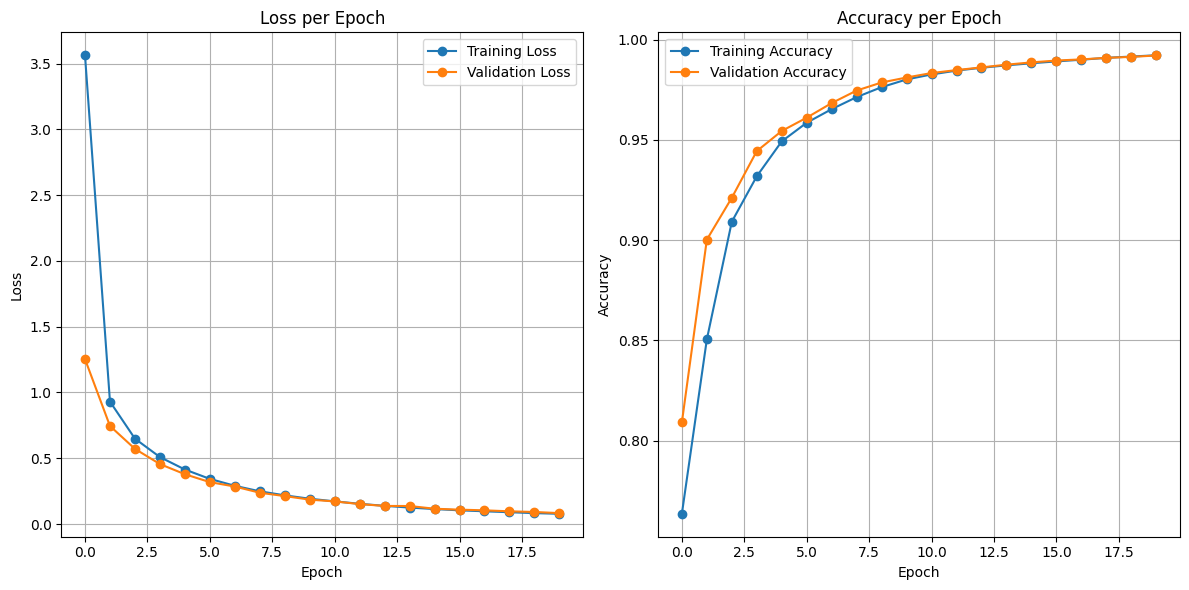

In [33]:
import matplotlib.pyplot as plt

# Plotting Loss and Accuracy
fig, axes = plt.subplots(1, 2, figsize=(12, 6))

# Loss Plot
axes[0].plot(epoch_train_loss, label='Training Loss', marker='o')
axes[0].plot(epoch_val_loss, label='Validation Loss', marker='o')
axes[0].set_title('Loss per Epoch')
axes[0].set_xlabel('Epoch')
axes[0].set_ylabel('Loss')
axes[0].legend()
axes[0].grid(True)

# Accuracy Plot
axes[1].plot(epoch_train_acc, label='Training Accuracy', marker='o')
axes[1].plot(epoch_val_acc, label='Validation Accuracy', marker='o')
axes[1].set_title('Accuracy per Epoch')
axes[1].set_xlabel('Epoch')
axes[1].set_ylabel('Accuracy')
axes[1].legend()
axes[1].grid(True)

plt.tight_layout()
plt.show()


In [ ]:
# # Load the best model
# model_name ='encoder_decoder_epoch_final1.pth'
# model.load_state_dict(torch.load(model_name))
# model.to(device)

## Model Predictions

In [44]:
def predict(model, dataloader, tokenizer, device):
    """
    Generates predictions for the input data using the trained model and calculates accuracy.
    """
    model.eval()
    predictions = []
    targets = []
    total_correct = 0
    total_tokens = 0
    
    with torch.no_grad():
        for batch in tqdm(dataloader, desc="Generating Predictions"):
            # Unpack batch
            img_features, reports, captions, lengths = batch
            
            # Move data to the same device as the model
            img_features = img_features.to(device)
            reports = reports.to(device)
            captions = captions.to(device)
            lengths = torch.tensor(lengths).to(device)
            
            # Forward pass
            outputs, _ = model(reports, img_features, captions, lengths)  # Adjust call to include captions and lengths
            
            # Get predicted token indices
            predicted_indices = torch.argmax(outputs, dim=2)  # [B, seq_len]
            
            # Decode predictions and ground truth
            for i in range(predicted_indices.size(0)):  # Iterate over batch
                pred_tokens = tokenizer.sequences_to_texts([predicted_indices[i].tolist()])[0]
                target_tokens = tokenizer.sequences_to_texts([captions[i].tolist()])[0]
                
                predictions.append(pred_tokens)
                targets.append(target_tokens)
                
            # Calculate accuracy
            # Ignore padding tokens (<PAD>) in accuracy calculation
            for i in range(captions.size(0)):  # Iterate over batch
                valid_tokens = lengths[i]  # Number of non-padding tokens
                total_correct += (predicted_indices[i, :valid_tokens] == captions[i, :valid_tokens]).sum().item()
                total_tokens += valid_tokens
    
    accuracy = total_correct / total_tokens if total_tokens > 0 else 0
    print(f"Accuracy: {accuracy:.4f}")
    return predictions, targets, accuracy


In [45]:
# Predict on validation dataset
test_predictions, test_ground_truth,test_accuracy = predict(model, data_loader_test, tokenizer, device)

# Display some predictions and ground truth
for i in range(5):
    print(f"Prediction {i + 1}: {test_predictions[i]}")
    print(f"Ground Truth {i + 1}: {test_ground_truth[i]}")
    print("-" * 50)
    
print(f"Test Accuracy: {test_accuracy:.4f}")

Generating Predictions:   0%|          | 0/13 [00:00<?, ?it/s]/tmp/ipykernel_2055641/1405944962.py:20: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  lengths = torch.tensor(lengths).to(device)
Generating Predictions: 100%|██████████| 13/13 [00:25<00:00,  2.00s/it]

Accuracy: 0.9914
Prediction 1: startseq the cardiomediastinal silhouette within normal limits lungs are clear without areas focal consolidation no pneumothora large pleural effusion endseq
Ground Truth 1: startseq the cardiomediastinal silhouette within normal limits lungs are clear without areas focal consolidation no pneumothora large pleural effusion endseq
--------------------------------------------------
Prediction 2: startseq the heart and lungs have the interval both lungs are clear and epanded heart and mediastinum normal endseq
Ground Truth 2: startseq the heart and lungs have the interval both lungs are clear and epanded heart and mediastinum normal endseq
--------------------------------------------------
Prediction 3: startseq heart size and pulmonary vascularity within normal limits no focal infiltrate pneumothora pleural effusion identified endseq
Ground Truth 3: startseq heart size and pulmonary vascularity within normal limits no focal infiltrate pneumothora pleural ef

## Evaluate Metrics

In [46]:

def compute_bleu(predictions, targets):
    """
    Calculates the average BLEU score for all predictions.
    
    Args:
        predictions: List of predicted sentences.
        targets: List of ground truth sentences.
    
    Returns:
        avg_bleu: Average BLEU score across all predictions.
    """
    scores = []
    for pred, target in zip(predictions, targets):
        target_tokens = target.split()
        pred_tokens = pred.split()
        score = sentence_bleu([target_tokens], pred_tokens)
        scores.append(score)
    avg_bleu = sum(scores) / len(scores)
    return avg_bleu

def compute_rouge(predictions, references):
    """
    Computes ROUGE scores for the given predictions and references.

    Args:
        predictions (list): List of predicted reports (strings).
        references (list): List of ground truth reports (strings).

    Returns:
        rouge_scores (dict): Dictionary with average ROUGE-1, ROUGE-2, and ROUGE-L scores.
    """
    scorer = rouge_scorer.RougeScorer(['rouge1', 'rouge2', 'rougeL'], use_stemmer=True)
    scores = {'rouge1': [], 'rouge2': [], 'rougeL': []}

    for pred, ref in tqdm(zip(predictions, references), total=len(predictions), desc="Computing ROUGE"):
        score = scorer.score(ref, pred)
        for key in scores.keys():
            scores[key].append(score[key].fmeasure)  # Use F1-score as the metric
    
    # Average the scores across all examples
    avg_scores = {key: sum(value) / len(value) for key, value in scores.items()}
    return avg_scores


In [47]:
# Compute ROUGE scores
rouge_scores = compute_rouge(test_predictions, test_ground_truth)
print("ROUGE Scores:")
print(f"ROUGE-1: {rouge_scores['rouge1']:.4f}")
print(f"ROUGE-2: {rouge_scores['rouge2']:.4f}")
print(f"ROUGE-L: {rouge_scores['rougeL']:.4f}")

# Compute BLEU score
bleu_score = compute_bleu(test_predictions, test_ground_truth)
print(f"BLEU Score: {bleu_score:.4f}")

Computing ROUGE: 100%|██████████| 399/399 [00:00<00:00, 580.25it/s]


ROUGE Scores:
ROUGE-1: 0.9683
ROUGE-2: 0.9397
ROUGE-L: 0.9683
BLEU Score: 0.9264


In [49]:
def compute_f1_precision_recall(predictions, references, tokenizer):
    """
    Computes F1-Score, Precision, and Recall for the predictions against the references.

    Args:
        predictions (list): List of predicted sentences (strings).
        references (list): List of ground truth sentences (strings).
        tokenizer: Tokenizer used in the dataset for word-index mapping.

    Returns:
        metrics (dict): Dictionary containing F1-Score, Precision, and Recall.
    """
    # Flatten token-level predictions and references
    pred_tokens = []
    ref_tokens = []
    pad_idx = tokenizer.word_index["<PAD>"]

    for pred, ref in zip(predictions, references):
        pred_indices = [tokenizer.word_index.get(word, pad_idx) for word in pred.split()]
        ref_indices = [tokenizer.word_index.get(word, pad_idx) for word in ref.split()]
        
        # Ensure both sequences have the same length
        min_length = min(len(pred_indices), len(ref_indices))
        pred_tokens.extend(pred_indices[:min_length])
        ref_tokens.extend(ref_indices[:min_length])
    
    # Compute Precision, Recall, and F1-Score
    precision = precision_score(ref_tokens, pred_tokens, average="weighted",zero_division=0)
    recall = recall_score(ref_tokens, pred_tokens, average="weighted",zero_division=0)
    f1 = f1_score(ref_tokens, pred_tokens, average="weighted",zero_division=0)

    return {"Precision": precision, "Recall": recall, "F1-Score": f1}


In [50]:
# Compute F1, Precision, and Recall
metrics = compute_f1_precision_recall(test_predictions, test_ground_truth, tokenizer)
print(f"Precision: {metrics['Precision']:.4f}")
print(f"Recall: {metrics['Recall']:.4f}")
print(f"F1-Score: {metrics['F1-Score']:.4f}")


Precision: 0.8765
Recall: 0.9130
F1-Score: 0.8934
